SVD Model

Epoch 1, Loss: 56.321346617126466
Epoch 2, Loss: 41.7852192489624
Epoch 3, Loss: 32.18804014892578
Epoch 4, Loss: 25.34730265045166
Epoch 5, Loss: 20.085502430725096
Epoch 6, Loss: 15.927400928497315
Epoch 7, Loss: 12.641640477371215
Epoch 8, Loss: 10.051032919311524
Epoch 9, Loss: 8.014350327110291
Epoch 10, Loss: 6.415893272209168
Epoch 11, Loss: 5.163033543968201
Epoch 12, Loss: 4.18226437702179
Epoch 13, Loss: 3.408739719772339
Epoch 14, Loss: 2.799895720863342
Epoch 15, Loss: 2.316353647041321
Epoch 16, Loss: 1.9292048629283904
Epoch 17, Loss: 1.6188119500637055
Epoch 18, Loss: 1.3685192975521088
Epoch 19, Loss: 1.1638253778457641
Epoch 20, Loss: 0.9968342779159546
Epoch 21, Loss: 0.8582733073234559
Epoch 22, Loss: 0.7427913428544998
Epoch 23, Loss: 0.6470621772050857
Epoch 24, Loss: 0.5660071052789688
Epoch 25, Loss: 0.49710585032701493
Test Loss: 13.398453328556146
Top 3 recommended movies for user 24 (SVD Model):
[51, 1647, 1107]


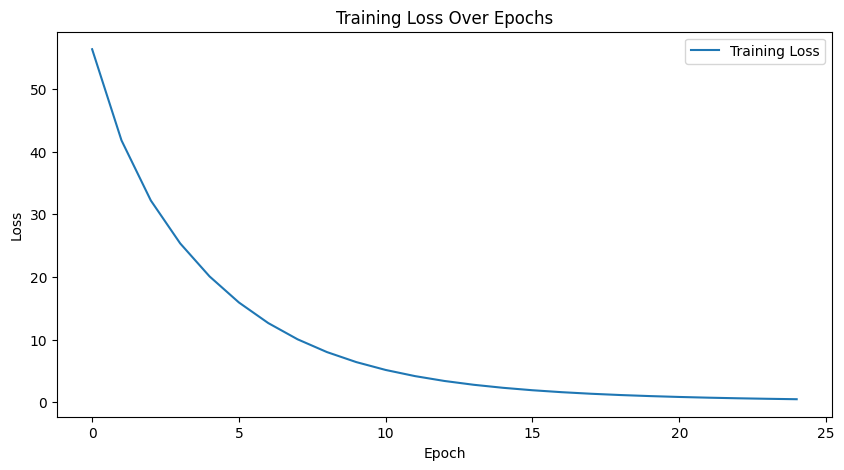

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Generate synthetic MovieLens 100K-like dataset
def generate_movielens_data(num_users=943, num_movies=1682, num_ratings=100000, seed=42):
    np.random.seed(seed)
    users = np.random.randint(1, num_users + 1, size=num_ratings)
    movies = np.random.randint(1, num_movies + 1, size=num_ratings)
    ratings = np.random.randint(1, 6, size=num_ratings)  # Ratings from 1 to 5

    data = pd.DataFrame({
        'userId': users,
        'movieId': movies,
        'rating': ratings
    })

    return data

# Custom dataset class
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.users = torch.tensor(data['userId'].values - 1, dtype=torch.long)  # Adjusting IDs to start from 0
        self.movies = torch.tensor(data['movieId'].values - 1, dtype=torch.long)  # Adjusting IDs to start from 0
        self.ratings = torch.tensor(data['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

# Generate synthetic MovieLens-like data
train_data = generate_movielens_data(num_ratings=80000)
test_data = generate_movielens_data(num_ratings=20000)

# Custom DataLoader
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# SVD-based Movie Recommendation Model
class SVD(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=50):
        super(SVD, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        self.global_bias = nn.Parameter(torch.tensor(0.0))

    def forward(self, users, movies):
        user_emb = self.user_embedding(users)
        movie_emb = self.movie_embedding(movies)
        user_b = self.user_bias(users).squeeze()
        movie_b = self.movie_bias(movies).squeeze()

        preds = torch.sum(user_emb * movie_emb, dim=1) + user_b + movie_b + self.global_bias
        return preds

# Train the SVD model
num_users = max(train_data['userId'].max(), test_data['userId'].max())  # Adjusting for 0-based indexing
num_movies = max(train_data['movieId'].max(), test_data['movieId'].max())  # Adjusting for 0-based indexing
model = SVD(num_users, num_movies)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25
train_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for users, movies, ratings in train_loader:
        optimizer.zero_grad()
        outputs = model(users, movies).squeeze()
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_train_loss}')

# Evaluate the SVD model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for users, movies, ratings in test_loader:
        outputs = model(users, movies).squeeze()
        loss = criterion(outputs, ratings)
        test_loss += loss.item()
    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss}')

# Function to recommend movies for a user
def recommend_movies_svd(user_id, model, num_movies, top_n=3):
    user_input = torch.tensor([user_id] * num_movies, dtype=torch.long)
    movie_input = torch.tensor(list(range(num_movies)), dtype=torch.long)
    model.eval()
    with torch.no_grad():
        ratings = model(user_input, movie_input).squeeze()
        recommended_movie_ids = torch.argsort(ratings, descending=True)[:top_n].tolist()
    return recommended_movie_ids

# Example usage
user_id = 24
recommended_movie_ids = recommend_movies_svd(user_id, model, num_movies, top_n=3)
print(f"Top 3 recommended movies for user {user_id} (SVD Model):")
print(recommended_movie_ids)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


EnhancedMovieLens Model

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define vocabulary for user IDs and movie titles
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

# Define user and movie models with additional features
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the retrieval task with additional metrics
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model),
    ks=[5, 10]
))

# Define the model
class EnhancedMovieLensModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

# Create and compile the model
model = EnhancedMovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the model
model.fit(ratings.batch(4096), epochs=5)

# Set up brute-force search for retrieval
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Get recommendations
_, titles = index(np.array(["2"]))
print(f"Top 3 recommendations for user 2: {titles[0, :3]}")


Epoch 1/5
25/25 [==============================] - 22s 800ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0068 - factorized_top_k/top_10_categorical_accuracy: 0.0135 - loss: 32331.2043 - regularization_loss: 0.0000e+00 - total_loss: 32331.2043
Epoch 2/5
25/25 [==============================] - 18s 714ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0076 - factorized_top_k/top_10_categorical_accuracy: 0.0162 - loss: 31507.4165 - regularization_loss: 0.0000e+00 - total_loss: 31507.4165
Epoch 3/5
25/25 [==============================] - 19s 742ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0078 - factorized_top_k/top_10_categorical_accuracy: 0.0176 - loss: 30977.5889 - regularization_loss: 0.0000e+00 - total_loss: 30977.5889
Epoch 4/5
25/25 [==============================] - 19s 774ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0111 - factorized_top_k/top_10_categorical_accuracy: 0.0236 - loss: 30615.5863 - regularization_loss: 0.0000e+00 - total_loss:

Genre-based Movie Recommendation Model

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample movie data (replace with your actual dataset)
movies_data = {
    'Title': ['Avatar', 'Titanic', 'The Avengers', 'The Lion King', 'The Hangover'],
    'Genre': ['Action|Adventure|Sci-Fi', 'Drama|Romance', 'Action|Sci-Fi', 'Animation|Adventure|Drama', 'Comedy']
}

# Convert to DataFrame
movies_df = pd.DataFrame(movies_data)

# Create a TF-IDF Vectorizer to transform genres into numerical vectors
tfidf = TfidfVectorizer(stop_words='english', tokenizer=lambda x: x.split('|'))
genre_matrix = tfidf.fit_transform(movies_df['Genre'])

# Compute cosine similarity matrix based on genre vectors
cosine_sim = cosine_similarity(genre_matrix, genre_matrix)

# Function to recommend movies based on genre similarity
def recommend_movies_based_on_genre(movie_title, movies_df, cosine_sim, top_n=3):
    # Get index of the movie title
    idx = movies_df.index[movies_df['Title'] == movie_title][0]

    # Get similarity scores with all movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top-n similar movie indices
    movie_indices = [i[0] for i in sim_scores[1:top_n+1]]  # Exclude the first item (itself)

    # Return top-n recommended movie titles
    return movies_df['Title'].iloc[movie_indices].tolist()

# Example usage:
movie_title = 'Avatar'  # Replace with any movie title from your dataset
recommended_movies = recommend_movies_based_on_genre(movie_title, movies_df, cosine_sim)

# Print recommended movies
print(f"Top {len(recommended_movies)} recommended movies similar to '{movie_title}':")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")

Top 3 recommended movies similar to 'Avatar':
1. The Avengers
2. The Lion King
3. Titanic
